In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
import cv2
import os
import pickle
from imutils import paths
from tqdm import tqdm
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model, models, layers
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import Xception, ResNet152, InceptionV3, NASNetLarge
%matplotlib inline



In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "dataset",
        shuffle=True,
        image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE
    )

Found 5530 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Brown_Rust', 'Healthy', 'Loose_Smut', 'Septoria', 'Yellow_Rust']

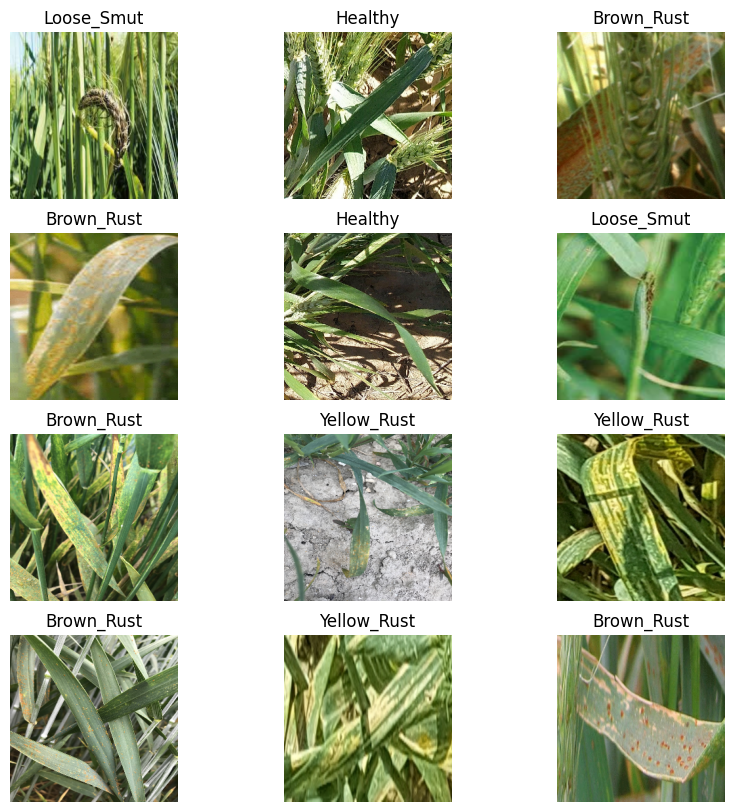

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_dataset = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [10]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

#VGG19 model

In [11]:
headmodel = VGG19(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (256, 256, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(len(class_names), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

In [12]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:

fitted_model = final_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=1
)


Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 992s 7s/step - accuracy: 0.6032 - loss: 1.7474 - val_accuracy: 0.8732 - val_loss: 0.4194
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 848s 6s/step - accuracy: 0.8499 - loss: 0.4561 - val_accuracy: 0.9301 - val_loss: 0.2536
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 1337s 10s/step - accuracy: 0.9037 - loss: 0.2664 - val_accuracy: 0.9430 - val_loss: 0.1835
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 695s 5s/step - accuracy: 0.9269 - loss: 0.1874 - val_accuracy: 0.9577 - val_loss: 0.1421
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 694s 5s/step - accuracy: 0.9519 - loss: 0.1332 - val_accuracy: 0.9577 - val_loss: 0.1581
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2758s 20s/step - accuracy: 0.9633 - loss: 0.1114 - val_accuracy: 0.9761 - val_loss: 0.1046
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 761s 6s/step - accuracy: 0.9740 - loss: 0.0798 - val_accuracy: 0.9706 - val_loss: 0.1116
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 742s 5s/step - accuracy: 0.9843 - loss: 0.0563 - val_

In [14]:
scores= final_model.evaluate(test_ds)

18/18 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.9857 - loss: 0.0604


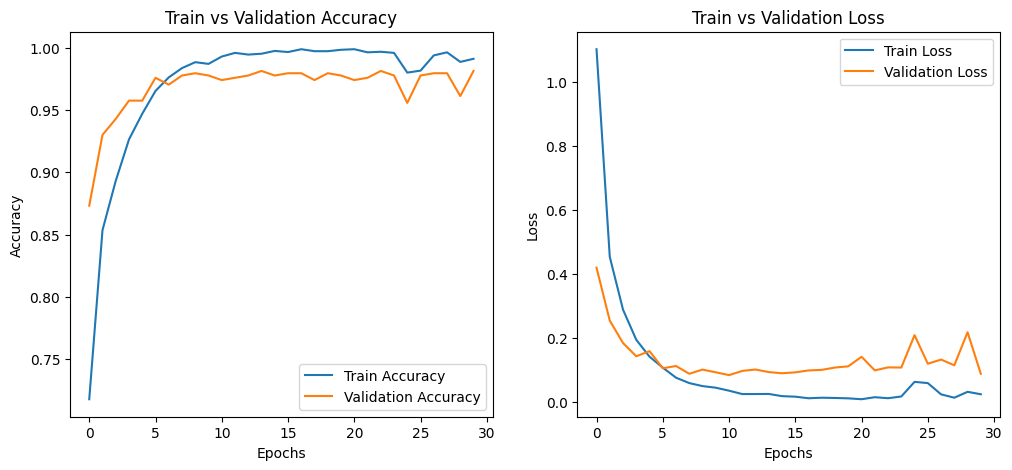

In [ ]:
import matplotlib.pyplot as plt

history = fitted_model.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


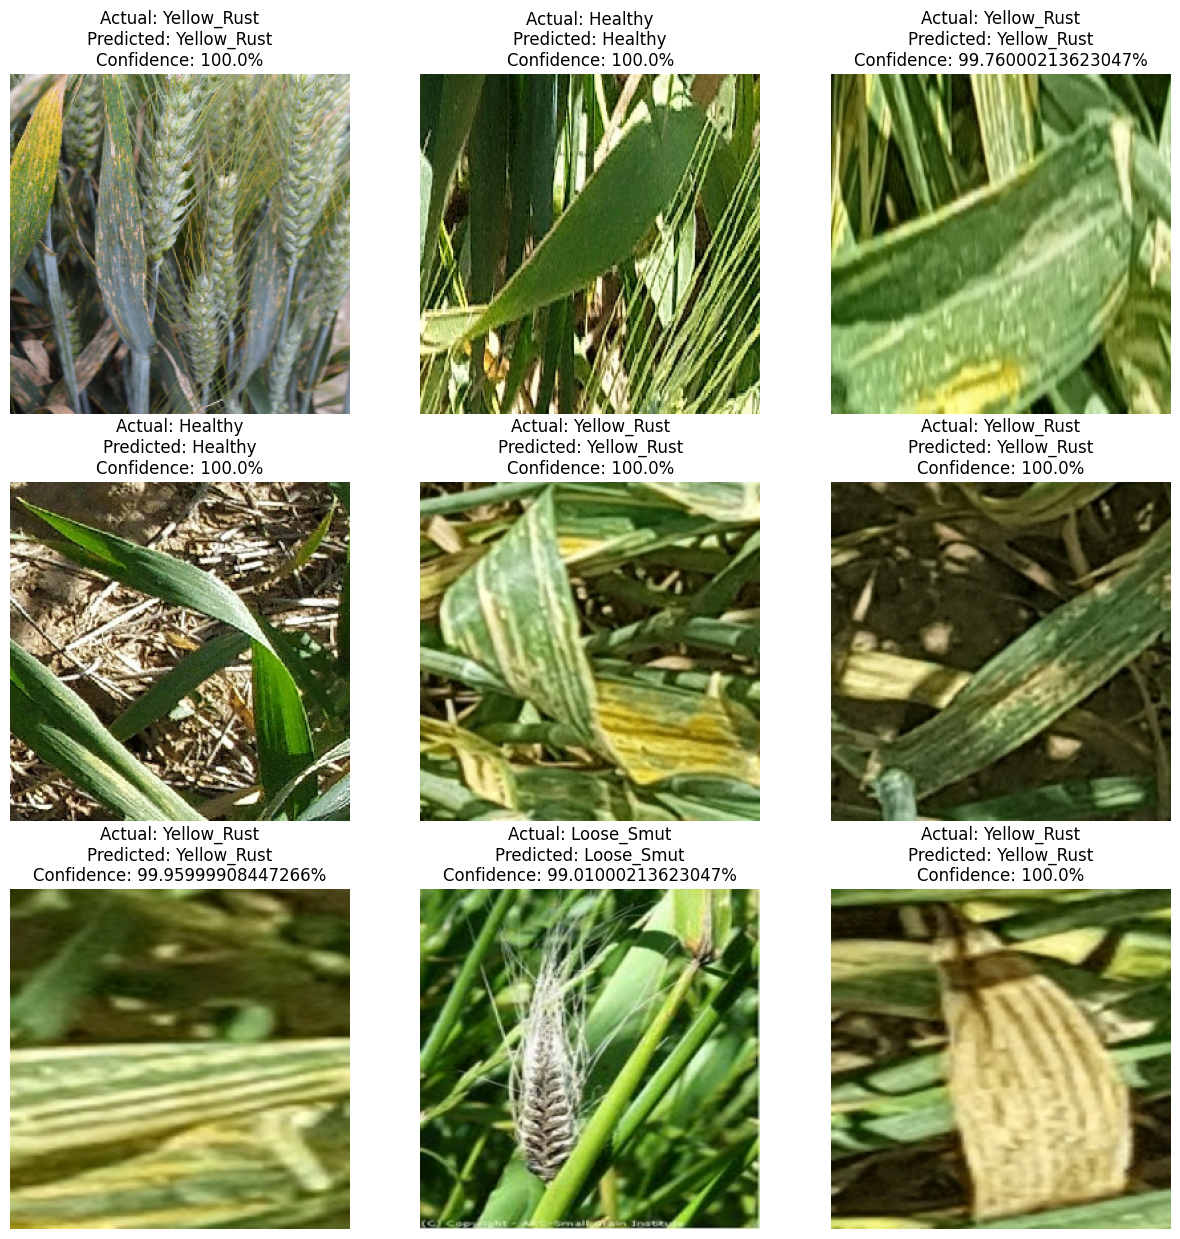

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

plt.figure(figsize=(15, 15))

for images, labels in test_dataset.take(1):  
    for i in range(9):  
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(final_model, images[i])
        actual_class = class_names[labels[i].numpy()]  

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis('off')

plt.show()

In [20]:
final_model.save("model_4.keras")  

In [ ]:
`   `